In [22]:
import torch
import experiments.autoencoder_experiment_ver4 as AE
from Models.AutoEncoder import *
from utils.utils import *
import numpy as np
import pandas as pd
# Confusion Matrix 계산 및 시각화
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
cat_features = [
    'Gender',
    'Zipcode',
    'Day',
    'Card Brand',
    'Card Type',
    'Has Chip',
    'Whether Security Chip is Used',
    'Error Message',
    'WeekDay',
    'Credit Signal',
    'PIN Change',
    'Security Level'
]
num_features = [
    'Current Age',
    'Retirement Age',
    'Per Capita Income - Zipcode',
    'Yearly Income',
    'Total Debt',
    'Credit Score',
    'Valid Month',
    'Credit Limit',
    'Since Open Month',
    'Year PIN last Changed',
    'Amount',
    'Credit Util',
    'Years Changed PIN',
    'Security Score'
]
discarded = [
    'User',
    'Birth Year',
    'Birth Month',
    'Year',
    'Month',
    'Merchandise Code',
    'Card',
    'Card Number',
    'Expires',
    'Acct Open Date',
]

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model_path = 'experiments/AutoEncoder4/AE4_dim26_batch256_lr0.000039_l10.000002.pth'

model = AE.AutoEncoder(encoding_dim=26, cat_features=cat_features, num_features=num_features, num_classes=1)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
print(model)

/tmp/ipykernel_291106/365089155.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


AutoEncoder(
  (cat_embeddings): ModuleList(
    (0-11): 12 x Embedding(100, 5)
  )
  (fc_cat): Linear(in_features=74, out_features=64, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=26, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=26, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=48, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=74, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Re

In [27]:
(train_cat_X, train_num_X, train_y), (valid_cat_X, valid_num_X, valid_y), _ , _= process_data(
    './Data/[24-2 DS_Project2] Data.csv', 
    cat_features, 
    num_features,
    discarded
)

TRANSITION
IQR
SPLIT
DISCARD
SCALE
ENCODE
UNLABEL
TARGET
TRAIN CAT/NUM
VALID CAT/NUM
RETURN


In [28]:
valid_dataset = AE_validDataset(valid_cat_X, valid_num_X, valid_y, device)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
criterion = nn.MSELoss()

Validation Loss: 0.0069
F1 Score: 0.0010
Threshold: 0.0117


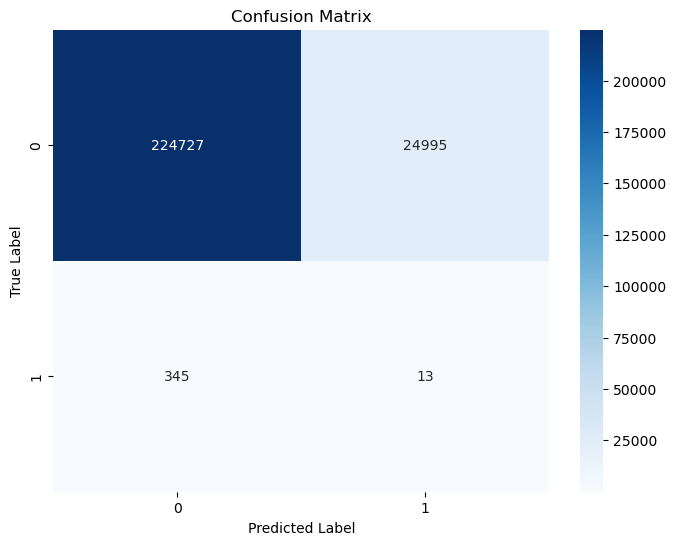

In [14]:
model.eval()
valid_loss = 0
reconstruction_errors = []
true_labels = []

with torch.no_grad():
    for cat_features, num_features, labels in valid_loader:
        y_hat, y = model(cat_features, num_features)
        batch_loss = criterion(y_hat, y)
        valid_loss += batch_loss.item()
        
        # 재구성 오차 저장
        errors = torch.mean((y_hat - y) ** 2, dim=1)
        reconstruction_errors.extend(errors.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    valid_loss /= len(valid_loader)
    
    # 재구성 오차의 임계값 설정 (예: 95 퍼센타일)
    threshold = np.percentile(reconstruction_errors, 90)
    
    # 이상치 탐지
    predictions = (np.array(reconstruction_errors) > threshold).astype(int)
    
    # 성능 평가
    f1 = f1_score(true_labels, predictions)
    print(f'Validation Loss: {valid_loss:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Threshold: {threshold:.4f}')



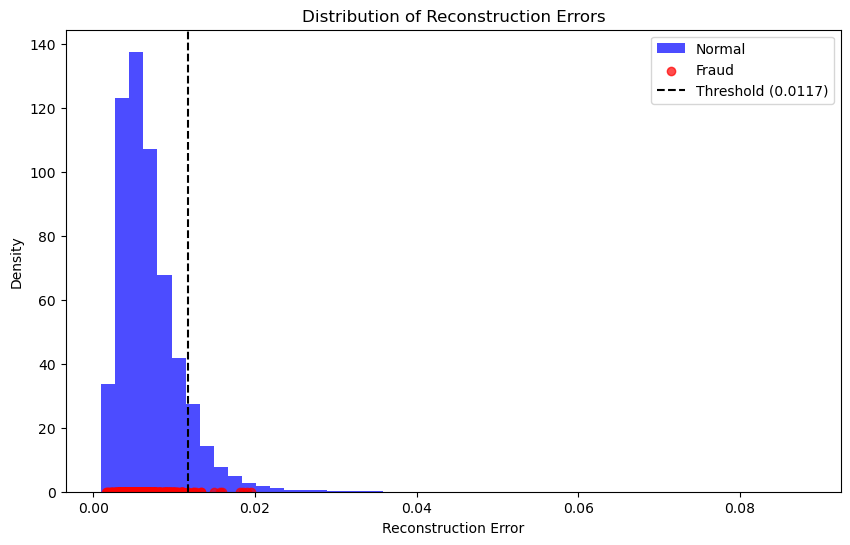

In [21]:
# 재구성 오차의 분포 시각화
plt.figure(figsize=(10, 6))

# 1차원 numpy 배열로 변환
reconstruction_errors_np = np.array(reconstruction_errors).flatten()
true_labels_np = np.array(true_labels).flatten()

# Fraud와 Non-fraud 데이터 분리
fraud_errors = reconstruction_errors_np[true_labels_np == 1]
normal_errors = reconstruction_errors_np[true_labels_np == 0]

# Normal 데이터는 히스토그램으로 표시
plt.hist(normal_errors, bins=50, alpha=0.7, color='blue', label='Normal', density=True)

# Fraud 데이터는 scatter plot으로 표시
y_positions = np.zeros_like(fraud_errors) # y축 위치를 0으로 설정
plt.scatter(fraud_errors, y_positions, color='red', alpha=0.7, label='Fraud', marker='o')

plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold ({threshold:.4f})')

plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.show()

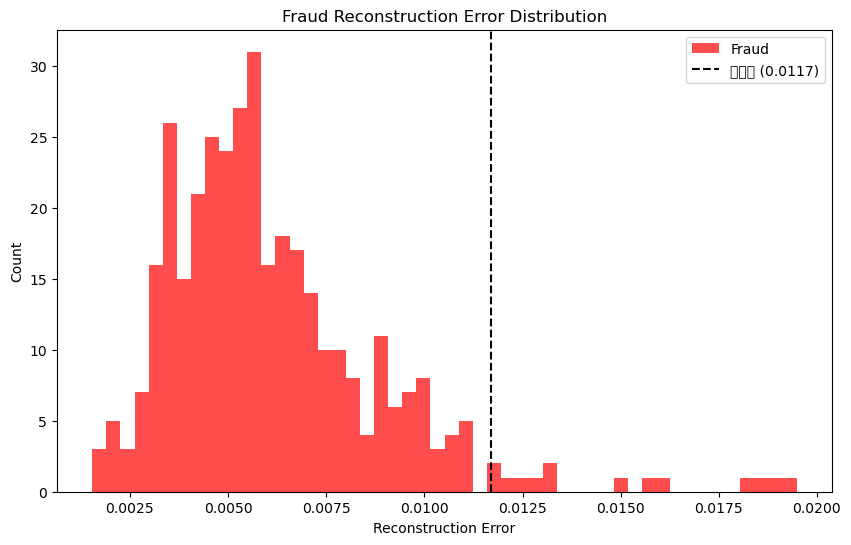

In [20]:
# Fraud 데이터에 대한 재구성 오차 분포만 시각화
plt.figure(figsize=(10, 6))

# Fraud 데이터만 필터링
fraud_errors = reconstruction_errors_np[true_labels_np == 1]

# 히스토그램 그리기 
plt.hist(fraud_errors, bins=50, color='red', alpha=0.7, label='Fraud')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'임계값 ({threshold:.4f})')

plt.title('Fraud Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:


cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Ver 4.1 결과 확인

In [25]:
import experiments.autoencoder_experiment_ver4_1 as AE_4_1


In [26]:
model_path = 'experiments/AutoEncoder4_1/AE4_1_dim31_batch256_lr0.000100_l10.000003.pth'

model = AE_4_1.AutoEncoder(encoding_dim=31, cat_features=cat_features, num_features=num_features, num_classes=1)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
print(model)

AutoEncoder(
  (cat_embeddings): ModuleList(
    (0-11): 12 x Embedding(100, 5)
  )
  (fc_cat): Linear(in_features=74, out_features=64, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=31, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=31, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=74, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


/tmp/ipykernel_291106/1181762509.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [29]:
model.eval()
valid_loss = 0
reconstruction_errors = []
true_labels = []

with torch.no_grad():
    for cat_features, num_features, labels in valid_loader:
        y_hat, y = model(cat_features, num_features)
        batch_loss = criterion(y_hat, y)
        valid_loss += batch_loss.item()
        
        # 재구성 오차 저장
        errors = torch.mean((y_hat - y) ** 2, dim=1)
        reconstruction_errors.extend(errors.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    valid_loss /= len(valid_loader)
    
    # 재구성 오차의 임계값 설정 (예: 95 퍼센타일)
    threshold = np.percentile(reconstruction_errors, 90)
    
    # 이상치 탐지
    predictions = (np.array(reconstruction_errors) > threshold).astype(int)
    
    # 성능 평가
    f1 = f1_score(true_labels, predictions)
    print(f'Validation Loss: {valid_loss:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Threshold: {threshold:.4f}')



Validation Loss: 0.0013
F1 Score: 0.0020
Threshold: 0.0020


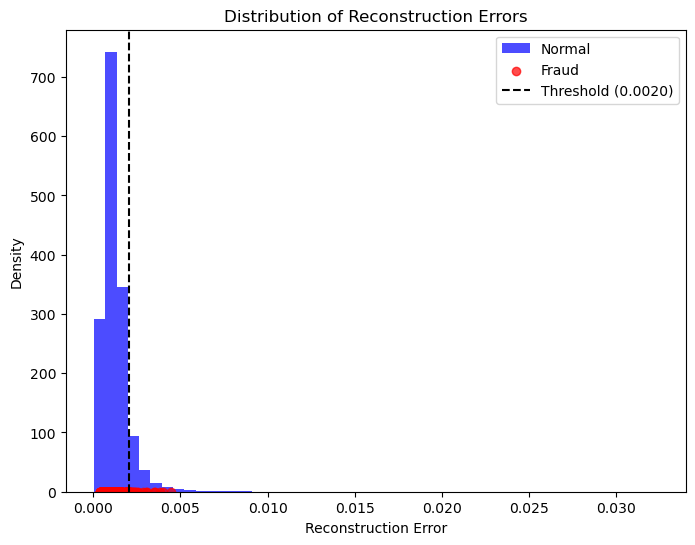

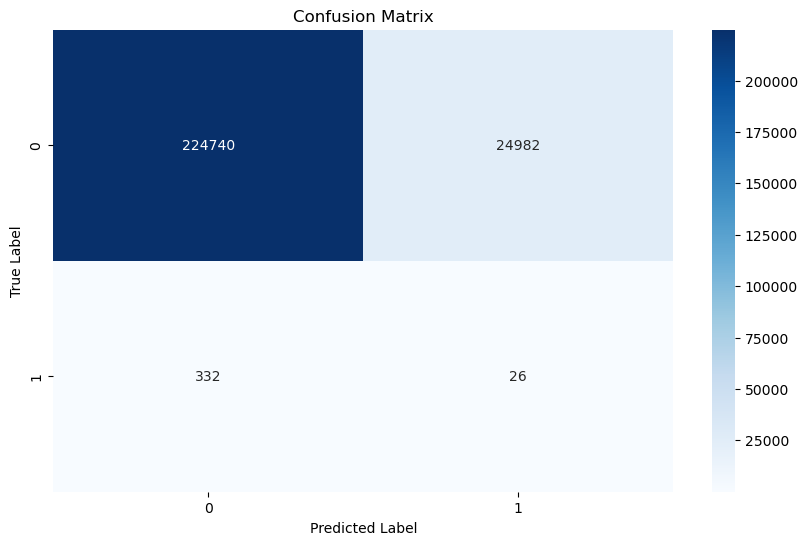

In [33]:
# 재구성 오차의 분포 시각화
plt.figure(figsize=(8, 6))

# 1차원 numpy 배열로 변환
reconstruction_errors_np = np.array(reconstruction_errors).flatten()
true_labels_np = np.array(true_labels).flatten()

# Fraud와 Non-fraud 데이터 분리
fraud_errors = reconstruction_errors_np[true_labels_np == 1]
normal_errors = reconstruction_errors_np[true_labels_np == 0]

# Normal 데이터는 히스토그램으로 표시
plt.hist(normal_errors, bins=50, alpha=0.7, color='blue', label='Normal', density=True)

# Fraud 데이터는 scatter plot으로 표시
y_positions = np.zeros_like(fraud_errors) # y축 위치를 0으로 설정
plt.scatter(fraud_errors, y_positions, color='red', alpha=0.7, label='Fraud', marker='o')

plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold ({threshold:.4f})')

plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.show()

# Confusion Matrix 계산 및 시각화
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


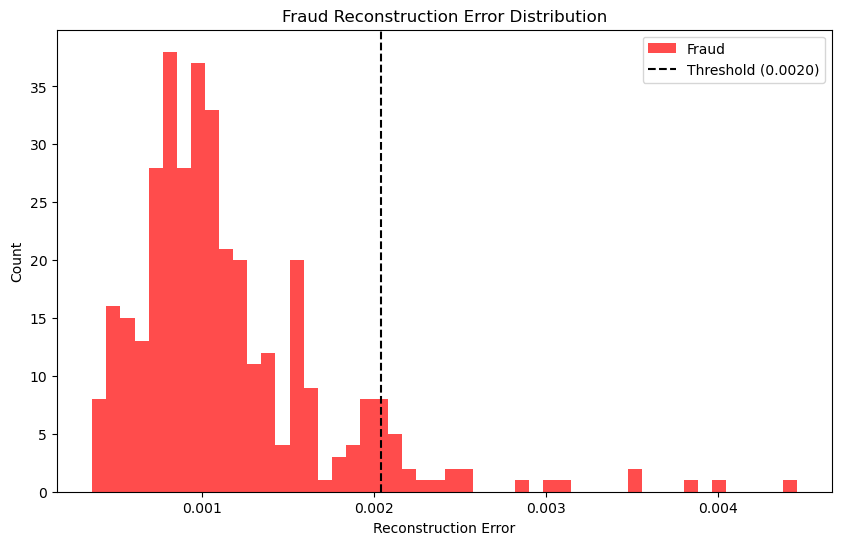

In [34]:
# Fraud 데이터에 대한 재구성 오차 분포만 시각화
plt.figure(figsize=(10, 6))

# Fraud 데이터만 필터링
fraud_errors = reconstruction_errors_np[true_labels_np == 1]

# 히스토그램 그리기 
plt.hist(fraud_errors, bins=50, color='red', alpha=0.7, label='Fraud')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold ({threshold:.4f})')

plt.title('Fraud Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()


<Figure size 1200x800 with 0 Axes>

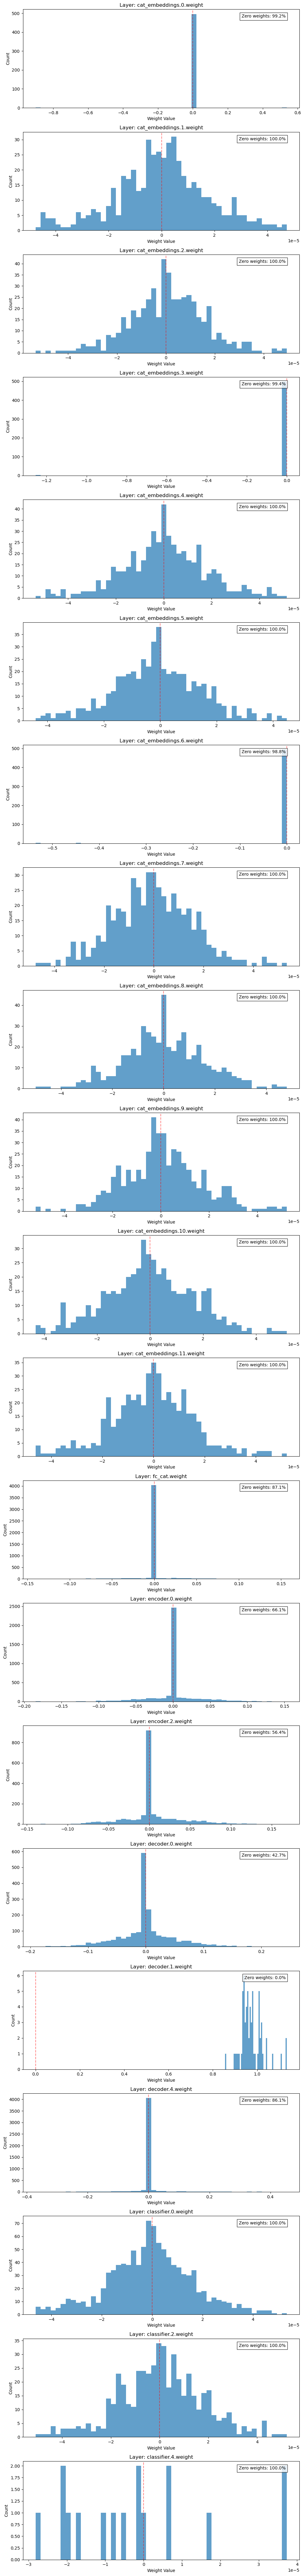

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

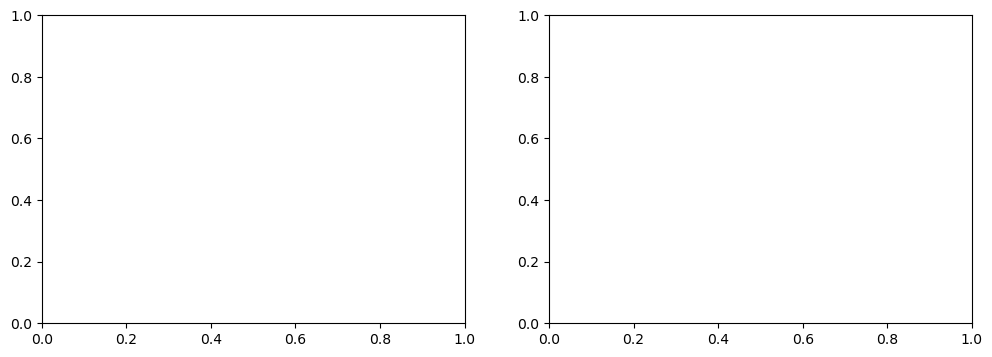

In [35]:
# 모델의 파라미터 분포 시각화
plt.figure(figsize=(12, 8))

# 레이어별 파라미터 분포를 시각화하기 위한 서브플롯 설정
num_layers = len([name for name, _ in model.named_parameters() if 'weight' in name])
fig, axes = plt.subplots(num_layers, 1, figsize=(10, 4*num_layers))

layer_idx = 0
for name, param in model.named_parameters():
    if 'weight' in name:  # weight 파라미터만 시각화
        # 파라미터 값을 numpy 배열로 변환
        weights = param.data.cpu().numpy().flatten()
        
        # 히스토그램 그리기
        axes[layer_idx].hist(weights, bins=50, alpha=0.7)
        axes[layer_idx].axvline(x=0, color='r', linestyle='--', alpha=0.5)  # 0 위치에 수직선
        axes[layer_idx].set_title(f'Layer: {name}')
        axes[layer_idx].set_xlabel('Weight Value')
        axes[layer_idx].set_ylabel('Count')
        
        # 0에 가까운 파라미터의 비율 계산 (절대값 0.01 이하)
        zero_weights = np.sum(np.abs(weights) < 0.01) / len(weights) * 100
        axes[layer_idx].text(0.95, 0.95, 
                           f'Zero weights: {zero_weights:.1f}%',
                           transform=axes[layer_idx].transAxes,
                           horizontalalignment='right',
                           verticalalignment='top',
                           bbox=dict(facecolor='white', alpha=0.8))
        
        layer_idx += 1

plt.tight_layout()
plt.show()

# BatchNorm 레이어의 running mean과 variance 분포 시각화
batch_norm_params = [(name, module) for name, module in model.named_modules() if isinstance(module, nn.BatchNorm1d)]

if batch_norm_params:
    fig, axes = plt.subplots(len(batch_norm_params), 2, figsize=(12, 4*len(batch_norm_params)))
    
    for idx, (name, bn_layer) in enumerate(batch_norm_params):
        # running mean 분포
        running_mean = bn_layer.running_mean.cpu().numpy()
        axes[idx, 0].hist(running_mean, bins=30, alpha=0.7)
        axes[idx, 0].set_title(f'{name} - Running Mean')
        axes[idx, 0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
        
        # running var 분포
        running_var = bn_layer.running_var.cpu().numpy()
        axes[idx, 1].hist(running_var, bins=30, alpha=0.7)
        axes[idx, 1].set_title(f'{name} - Running Variance')
        axes[idx, 1].axvline(x=1, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
